In [1]:
from utils import viz_camera_poses
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
from two_view_stereo import *


EPS = 1e-8


C:\Users\aniru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyglet\libs\win32\__init__.py:285: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
a = np.random.random((1024, 9, 3))
b = np.random.random((780, 9, 3))


In [3]:
src = a
dst = b

In [4]:
%%time
assert src.ndim == 3 and dst.ndim == 3
assert src.shape[1:] == dst.shape[1:]

err = np.zeros((src.shape[0], dst.shape[0]))
for i in range(src.shape[0]):
    for k in range(3):
        err[i, :] += [np.square(np.linalg.norm(src[i, :, k] - dst[j, :, k]))
                                for j in range(dst.shape[0])]
ssd = err

CPU times: total: 3.09 s
Wall time: 7.93 s


In [5]:
%%time
ssd1 = np.sum(np.square(np.linalg.norm(
    src[:, np.newaxis, :, :] - dst[np.newaxis, :, :, :], axis=2)), axis=2)


CPU times: total: 141 ms
Wall time: 293 ms


In [6]:
np.all((ssd1 == ssd))

True

In [7]:
%%time
err = np.zeros((src.shape[0], dst.shape[0]))
for i in range(src.shape[0]):
    # ########  #
    # 2 sums - > 1 for channel and 1 for patch and then loop comprehension  #
    # ########  #
    err[i, :] = np.array([np.sum(np.sum(np.abs(src[i, :, :] - dst[j, :, :]), axis=1), axis=0) for j in range(dst.shape[0])])

sad = err


CPU times: total: 1.97 s
Wall time: 5.46 s


In [8]:
%%time
absdiff = np.abs(src[:, np.newaxis, :, :] - dst[np.newaxis, :, :, :])
sad1 = np.abs(src[:, np.newaxis, :, :] -
              dst[np.newaxis, :, :, :]).sum(axis=3).sum(axis=2)


CPU times: total: 188 ms
Wall time: 393 ms


In [9]:
np.all((sad1 == sad))

True

In [10]:
EPS = 1e-8
from copy import deepcopy

In [11]:
%%time
err = np.zeros((src.shape[0], dst.shape[0]))
Wbar1 = np.mean(src, axis=1)
Wbar2 = np.mean(dst, axis=1)
sigma1 = np.std(src, axis=1)
sigma2 = np.std(dst, axis=1)
for i in range(src.shape[0]):
    # We will need to seperate channels here I think
    tmp = None
    for k in range(3):
        if tmp is None:
            tmp = np.array([np.sum((src[i, :, k]-Wbar1[i, k])*(dst[j, :, k]-Wbar2[j, k])/(
                sigma1[i, k]*sigma2[j, k]+EPS)) for j in range(dst.shape[0])])
        else:
            tmp += np.array(([np.sum((src[i, :, k]-Wbar1[i, k])*(dst[j, :, k]-Wbar2[j, k])/(
                sigma1[i, k]*sigma2[j, k]+EPS)) for j in range(dst.shape[0])]))
    err[i, :] = deepcopy(tmp)
zncc = -err


CPU times: total: 6.41 s
Wall time: 14.8 s


In [12]:
%%time
normsrc = (src-src.mean(axis = 1)[:, np.newaxis, :])
normdst = (dst-dst.mean(axis=1)[:, np.newaxis, :])
sigmasrc = np.std(src, axis=1)
sigmadst = np.std(dst, axis=1)

crossdiff = normsrc[:, np.newaxis, :, :]*normdst[np.newaxis, :, :, :]
denom = ((sigmasrc[:, np.newaxis, :]*sigmadst[np.newaxis, :, :])+EPS)

zncc1 = -(crossdiff.sum(axis = 2)/(denom)).sum(axis = 2)

CPU times: total: 93.8 ms
Wall time: 250 ms


In [13]:
np.all(zncc -zncc1 < 1e-8)

True

Loading data/templeRing


47it [00:00, 113.76it/s]


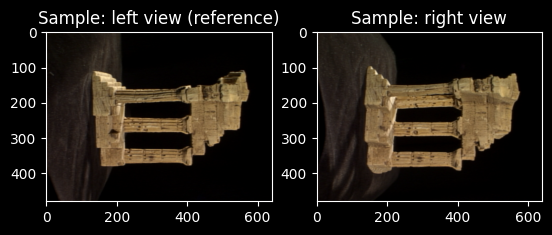

In [14]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]
# viz_camera_poses([view_i, view_j])

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()

In [15]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

R_wi, T_wi = view_i["R"], view_i["T"][:, None]  # p_i = R_wi @ p_w + T_wi
R_wj, T_wj = view_j["R"], view_j["T"][:, None]  # p_j = R_wj @ p_w + T_wj

R_ji, T_ji, B = compute_right2left_transformation(R_wi, T_wi, R_wj, T_wj)
assert T_ji[1, 0] > 0, "here we assume view i should be on the left, not on the right"



In [16]:
R_irect = compute_rectification_R(T_ji)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,
    R_irect @ R_ji,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)


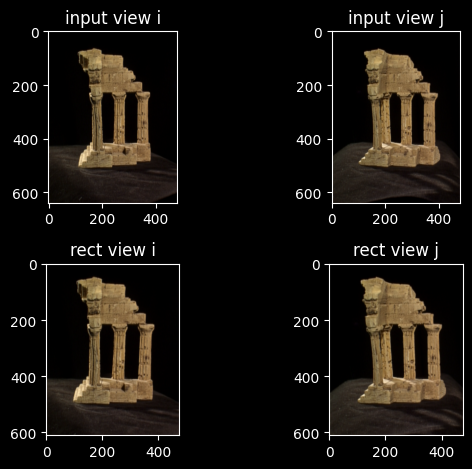

In [17]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()

In [18]:
image = rgb_i_rect.astype(float)/255.0

In [19]:
k_size = 3
p = k_size//2 #Pad Size
R = np.pad(image[:,:,0].copy(), p)
G = np.pad(image[:,:,1].copy(), p)
B = np.pad(image[:,:,2].copy(), p)

In [20]:
%%time
k_size = 3
p = k_size//2  # Pad Size
R = np.pad(image[:, :, 0].copy(), p)
G = np.pad(image[:, :, 1].copy(), p)
B = np.pad(image[:, :, 2].copy(), p)
PatchR= np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchG = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchB = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
for i in range(p, image.shape[0]+p):
    for j in range(p, image.shape[1]+p):
        PatchR[i-p, j-p, :] = R[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchG[i-p, j-p, :] = G[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchB[i-p, j-p, :] = B[i-p:i+1+p, j-p:j+1+p].ravel()
patch_buffer2 = np.stack((PatchR, PatchG, PatchB), axis=3)


CPU times: total: 578 ms
Wall time: 1.17 s


In [21]:
%%time
Rchannel = deepcopy(image[:, :, 0])
Gchannel = deepcopy(image[:, :, 1])
Bchannel = deepcopy(image[:, :, 2])

# Padding! x-> pixel; o-> pad
#      o o o
#      o x o
#      o o o
padsize = int(np.floor(k_size*0.5))
Rchannel = np.pad(Rchannel, padsize)
Gchannel = np.pad(Gchannel, padsize)
Bchannel = np.pad(Bchannel, padsize)

# Make patch image
shape = image.shape
Rpatch = np.zeros((shape[0], shape[1], k_size*k_size))
Gpatch = np.zeros_like(Rpatch)
Bpatch = np.zeros_like(Rpatch)

# vEcToriZAtiOn
for i in range(padsize, shape[0]+padsize):
    for j in range(padsize, shape[1]+padsize):
        Rpatch[i-padsize, j-padsize, :] = Rchannel[i -
                                                    padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()
        Gpatch[i-padsize, j-padsize, :] = Gchannel[i -
                                                    padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()
        Bpatch[i-padsize, j-padsize, :] = Bchannel[i -
                                                    padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()

# Combine all RGB channels
patch_buffer = np.stack((Rpatch, Gpatch, Bpatch), axis=3)


CPU times: total: 375 ms
Wall time: 1.3 s


In [22]:
np.all(patch_buffer == patch_buffer2)


True

In [23]:
rgb_i, rgb_j, d0 = rgb_i_rect, rgb_j_rect, K_j_corr[1,2] - K_i_corr[1,2]

In [26]:
k_size = 5
kernel_func = ssd_kernel

In [30]:
h, w = rgb_i.shape[:2]

patches_i = image2patch(rgb_i.astype(float) / 255.0, k_size)  # [h,w,k*k,3]
patches_j = image2patch(rgb_j.astype(float) / 255.0, k_size)  # [h,w,k*k,3]

disp_map = np.zeros((h, w), dtype=np.float64)
lr_consistency_mask = np.zeros((h, w), dtype=np.float64)

vi_idx, vj_idx = np.arange(h), np.arange(h)
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
valid_disp_mask = disp_candidates > 0.0
indexarr = np.arange(0, h, 1)

# for each column
for i in tqdm(range(w)):
    # Make Patch of each column
    patchcolumn_i, patchcolumn_j = patches_i[:, i], patches_j[:, i]
    errors = kernel_func(patchcolumn_i, patchcolumn_j)
    _upper = errors.max() + 1.0
    errors[~valid_disp_mask] = _upper

    # errors is a patchno. -> e1 e2 e3 matrix
    # We will get min error corresponding to all patches
    # This indice is for particular patch in left image
    leastindices = errors.argmin(axis=1)

    leastindices_Right = (errors[:, leastindices.flatten()]).argmin(axis=0)

    lr_consistency_mask[:, i] = (
        (vi_idx == leastindices_Right).flatten()).astype(float)

    disp_map[:, i] = (indexarr - leastindices + d0)


100%|██████████| 611/611 [02:15<00:00,  4.50it/s]


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02352941, 0.02745098, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03137255, 0.02745098, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.13333333, 0.13333333, ..., 0.00392157, 0.00392157,
        0.        ],
       [0.        , 0.12156863, 0.12156863, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
%%time
K = K_i_corr
B = 0.2241613446211245
dep_map = np.zeros_like(disp_map)
xyz_cam = np.zeros((dep_map.shape[0], dep_map.shape[1], 3))

for i in range(disp_map.shape[0]):
    dep_map[i, :] = [K[1, 1]*B/disp_map[i, j]
                        for j in range(disp_map.shape[1])]

x, y = np.meshgrid(
    np.arange(disp_map.shape[1]), np.arange(disp_map.shape[0]))

x_cam = ((x.flatten() - K[0, 2])*dep_map.flatten()/K[0, 0])
y_cam = (y.flatten() - K[1, 2])*dep_map.flatten()/K[1, 1]

joinedimage = np.stack([x_cam, y_cam, dep_map.flatten()]).T
xyz_cam = joinedimage.reshape((dep_map.shape[0], dep_map.shape[1], 3))

CPU times: total: 0 ns
Wall time: 141 ms


In [49]:
np.all(K[1,1]*B/disp_map == dep_map)

True

In [50]:
%%time
K = K_i_corr
B = 0.2241613446211245
dep_map = K[1, 1]*B/disp_map
xyz_cam = np.zeros((dep_map.shape[0], dep_map.shape[1], 3))

x, y = np.meshgrid(
    np.arange(disp_map.shape[1]), np.arange(disp_map.shape[0]))

x_cam = ((x.flatten() - K[0, 2])*dep_map.flatten()/K[0, 0])
y_cam = (y.flatten() - K[1, 2])*dep_map.flatten()/K[1, 1]

joinedimage = np.stack([x_cam, y_cam, dep_map.flatten()]).T
xyz_cam = joinedimage.reshape((dep_map.shape[0], dep_map.shape[1], 3))


CPU times: total: 0 ns
Wall time: 15.9 ms


In [51]:
from two_view_stereo import two_view, ssd_kernel, sad_kernel, zncc_kernel
from multiprocessing import Pool


def process_pair(pair):
    i, j = pair
    _pcl, _pcl_color, _disp_map, _dep_map = two_view(
        DATA[i], DATA[j], 5, sad_kernel)
    return _pcl, _pcl_color, _disp_map, _dep_map


pairs = [(0, 2), (2, 4), (5, 7), (8, 10), (13, 15),
         (16, 18), (19, 21), (22, 24), (25, 27)]

if __name__ == '__main__':
    with Pool() as pool:
        results = pool.map(process_pair, pairs)

    pcl_list = [result[0] for result in results]
    pcl_color_list = [result[1] for result in results]
    disp_map_list = [result[2] for result in results]
    dep_map_list = [result[3] for result in results]
